<h1 align="center">STARTING ASSUMPTIONS AND DECISIONS</h1> 

Firstly, I informed myself on NYC CitiBike payment types: 

1. **Single Ride** costs **3 USD/trip**: one ride up to 30 minutes, extra **3 USD for each additional 30 minutes**.


2. **Unlimited, day** costs **12 USD/day**  or **24 USD/3 days** : unlimited 30-minute rides in a 24-hour period, extra **4 USD for each additional 15 minutes**.


3. **Unlimited, year** costs **169 USD/year**: unlimited 45-minute rides, extra **2.50 USD for each additional 15 minutes**.

Given this information and considering users to be rational decision makers who try to avoid spending extra money, I assumed the following: 

<h3 align="center"> Assumption 1: Single Ride users would try to avoid trips > 120 min.</h3> 

*Reasoning:* If their trips are longer, they would spend more than 12 USD that is the price for the **Unlimited 1 day** pass. In other words, if they intended to spend at least 12 USD, they would go for the  **Unlimited 1 day** pass. So, I coucnlude that the majority of **Single Ride** users intend to spend less than 12 USD that means that they intend to cycle for < 120 min.

<h3 align="center"> Assumption 2: Both Unlimited 1 and 3 days users would try to avoid trips > 75 min.</h3> 

*Reasoning:* if the trip is longer than 75 min, **Unlimited 1 day** users would spend more than 24 USD which is the price for **Unlimited 3 days** pass, so if they intended to spend these money, they would have bought the latter. I assume that **Unlimited 3 day** users try to save money and pay less compared to buying 3 separate **Unlimited 1 day** passes, so they try to spend less than 36 USD. If they cycle > 75 min, they would  spend more than 36 USD that is in conflict with their intentions. Thus, both types try to avoid trips longer than 75 min.

<h3 align="center"> Assumption 3: Unlimited year users would try to avoid trips > 60 min.</h3> 

*Reasoning:* **Unlimited, year** users already pay 0.5 USD for each day. If they cycle longer than 60 min, they would pay more than 3 USD that is a price of the **Single Ride** pass. I assume that a person who buys a year subscription intends to avoid spending money for extra daily passes. 

Thus, trips > 120 min can be seen as outliers, beacuse these trips are economically risky and I assume that the majority of the users intend to avoid these risks. These long trips can be explained by, for example, stealing events or wrong bike installation at the return station. Additional analysis of such events can reveal more, however for the current analysis these events were seen as outliers. Thus, I made **Decision 1**.

<h3 align="center"> Decision 1: Delete trips > 120 min from the dataset.</h3> 

Also, trips shorter than 2 min can be seen as false starts. They can be caused, for example, by bike damages or a change in user's deciosion (e.g., decided to take a tram or just walk). Thus, I made **Decision 2**:

<h3 align="center"> Decision 2: Delete trips < 2 min from the dataset.</h3> 

<h1 align="center">SETUP</h1> 

In [1]:
# Set up the environmental variable and google application credentials
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/100kotton/Desktop/BQ/ny-citybikes-c4ce4e4a0ef9.json"

In [2]:
# Load packages
from IPython.display import GeoJSON
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely # manipulation and analysis of geometric objects
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import seaborn as sns
sns.set_style("darkgrid")
import calendar
%matplotlib inline
%load_ext google.cloud.bigquery

<h1 align="center">TASK 1</h1> 

<h1 align="center"> 1.1 What is the most popular start station?</h1>

<h3 align="center"> Answer: Pershing Square North is the most popular start station. </h3>

**Comment**: This bike station is close to the Grand Central Terminal which is both a busy transportation hub and historic NYC landmark, so I assume that both locals and tourists start their trips here.

<h2 align="center">Solution</h2> 

In [3]:
%%bigquery

SELECT 
start_station_name, 
COUNT(start_station_name) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY start_station_name
ORDER BY frequency DESC
LIMIT 1

start_station_name  frequency
0  Pershing Square North     435720

In [4]:
%%bigquery

SELECT 
longitude, latitude
FROM `bigquery-public-data.new_york_citibike.citibike_stations`
WHERE name = "Pershing Square North"

longitude   latitude
0 -73.977706  40.751873

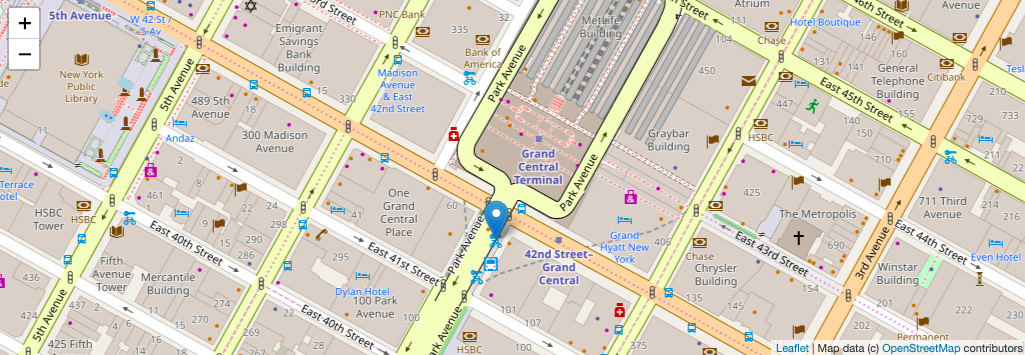

In [5]:
GeoJSON({
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [-73.977706, 40.751873]
    }
})
Image(filename="/Users/100kotton/Desktop/BQ/start.png", width=1000, height=600)

<h1 align="center"> 1.2 What is the most popular end station?</h1>

<h3 align="center"> Answer: E 17 St & Broadway is the most popular end station.</h3> 

<h2 align="center">Solution</h2> 

In [6]:
%%bigquery

SELECT end_station_name, 
COUNT(end_station_name) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY end_station_name
ORDER BY frequency DESC
LIMIT 1

end_station_name  frequency
0  E 17 St & Broadway     439710

In [7]:
%%bigquery

SELECT longitude, latitude
FROM `bigquery-public-data.new_york_citibike.citibike_stations`
WHERE name = "E 17 St & Broadway"

longitude  latitude
0 -73.990093  40.73705

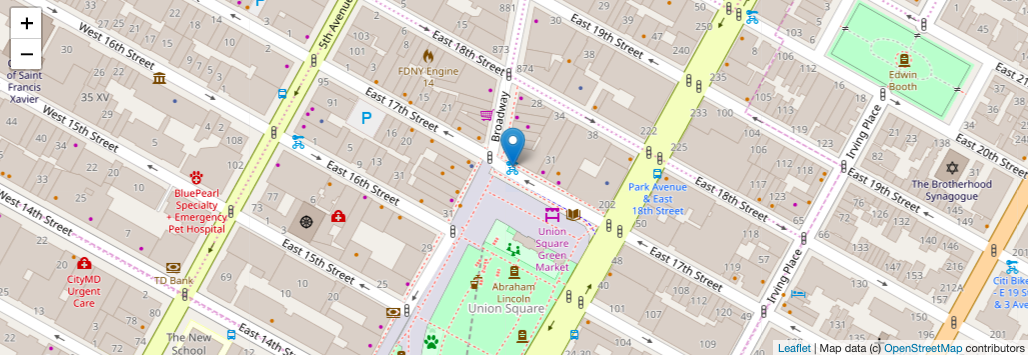

In [8]:
GeoJSON({
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [-73.990093, 40.73705]
    }
})
Image(filename = "/Users/100kotton/Desktop/BQ/end.png", width=1000, height=600)

<h3 align="center"> Let's see how the start and end stations are located in relation to each other. </h3> 

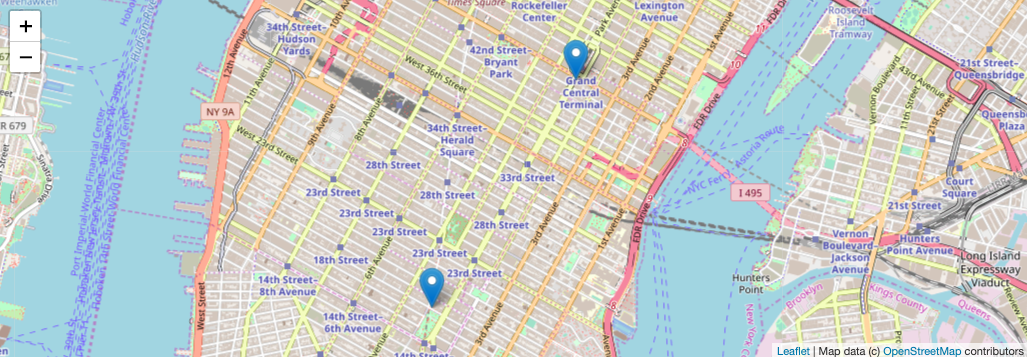

In [9]:
GeoJSON({
    "type": "Feature",
    "geometry": {
        "type": "MultiPoint",
        "coordinates": [[-73.977706, 40.751873],
                        [-73.990093, 40.73705]]
    }
})
Image(filename = "/Users/100kotton/Desktop/BQ/between.png", width=1000, height=600)

<h1 align="center"> 2. What is the gender distribution of Citibike users?</h1>

<h3 align="center"> Answer: 67% male, 22% female, 11% unknown.</h3> 

**Comment**: There are 3 times more men than women among CityBike users. This result is imporatnt for the marketing team: they might think that their current ads are more personalised towards men and some changes should be made to make CityBike attractive to women also.  

<h2 align="center">Solution</h2> 

In [10]:
%%bigquery gender_dist

SELECT gender, COUNT(gender) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY gender
ORDER BY frequency

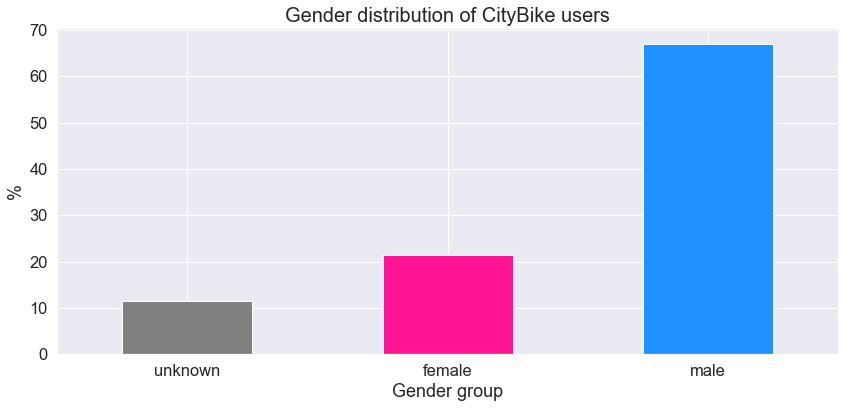

In [11]:
sns.set(font_scale=1.5)
gender_dist['percentage'] = gender_dist['frequency']/sum(gender_dist['frequency'])*100
gender_dist.plot(kind='bar', x='gender', y='percentage', color=['grey','deeppink','dodgerblue'], figsize=(14,6), legend = False)
plt.ylabel('%', fontsize=18)
plt.xlabel('Gender group', fontsize=18)
plt.title('Gender distribution of CityBike users', fontsize=20)
plt.xticks(rotation=0)
plt.show()

<h1 align="center">  3. What is the trip duration distribution of Citibike trips?</h1> 

<h3 align="center">  Answer: 50% of the trips are < 10 min, 99.9% of the trips are < 33 min.</h3> 

**Comment:** This finding is expected, because all subscription types (except for the annual one) imply extra costs for trips longer than 30 min. Thus, people try to avoid extra costs. Based on the frequency distribution plot below, I assume that trips longer than 68 minutes can be seen as anomalies. They might be caused, for example, by wrong installation of a bike at the return station. This situation can be very frustrating for a user, becuase she would have been charged for a long trip. Given that people are very busy and at the same time they do not like to be charged for such a mistake, the marketing team can send an email to this user and ask whether there are any problems.

<h2 align="center">Solution</h2> 

In [12]:
%%bigquery trip_duration

SELECT ROUND(tripduration/60) AS tripduration_min, COUNT(ROUND(tripduration/60)) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY tripduration_min
ORDER BY tripduration_min ASC

In [13]:
trip_duration['percentage'] = round(trip_duration.frequency*100/trip_duration.frequency.sum())
trip_duration['cumulative_percentage'] = 100*trip_duration.percentage.cumsum()/trip_duration.percentage.sum()
trip_duration.head(35)

tripduration_min  frequency  percentage  cumulative_percentage
0                2.0     675243         1.0               1.030928
1                3.0    2159832         4.0               5.154639
2                4.0    3030128         6.0              11.340206
3                5.0    3519946         7.0              18.556701
4                6.0    3677905         7.0              25.773196
5                7.0    3609156         7.0              32.989691
6                8.0    3407209         7.0              40.206186
7                9.0    3115753         6.0              46.391753
8               10.0    2804753         5.0              51.546392
9               11.0    2509787         5.0              56.701031
10              12.0    2238499         4.0              60.824742
11              13.0    1998299         4.0              64.948454
12              14.0    1787870         3.0              68.041237
13              15.0    1604905         3.0              71.134021
14              16.0    1446238         3.0              74.226804
15              17.0    1311918         3.0              77.319588
16              18.0    1193730         2.0              79.381443
17              19.0    1097281         2.0              81.443299
18              20.0    1009811         2.0              83.505155
19              21.0     931373         2.0              85.567010
20              22.0     861059         2.0              87.628866
21              23.0     794430         2.0              89.690722
22              24.0     735479         1.0              90.721649
23              25.0     675048         1.0              91.752577
24              26.0     620678         1.0              92.783505
25              27.0     566266         1.0              93.814433
26              28.0     512037         1.0              94.845361
27              29.0     460101         1.0              95.876289
28              30.0     407368         1.0              96.907216
29              31.0     360616         1.0              97.938144
30              32.0     320067         1.0              98.969072
31              33.0     286775         1.0             100.000000
32              34.0     254221         0.0             100.000000
33              35.0     226717         0.0             100.000000
34              36.0     202732         0.0             100.000000

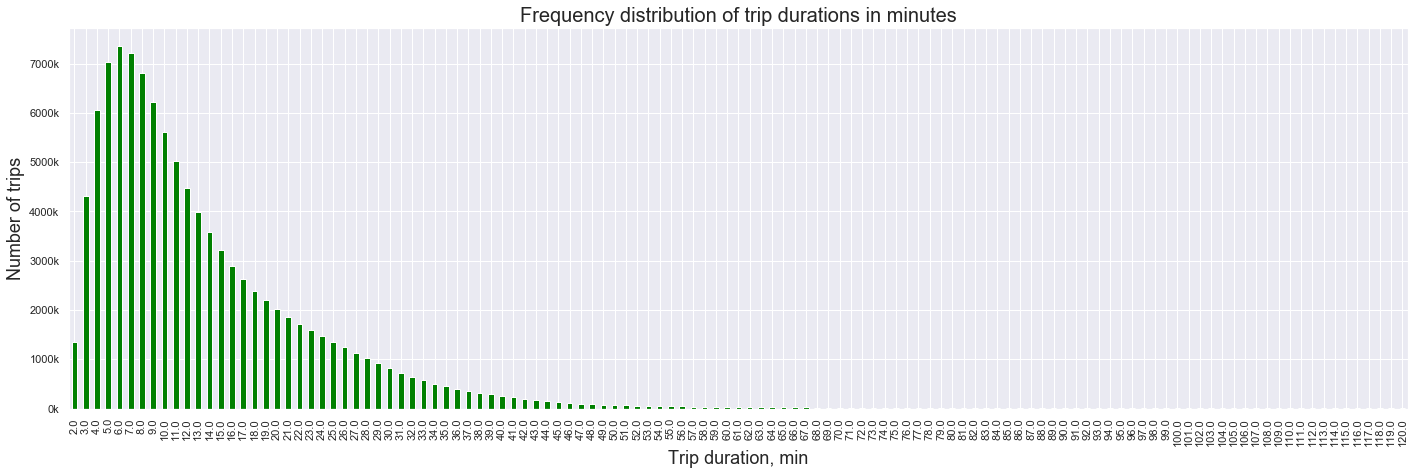

In [14]:
sns.set(font_scale=1)
h = trip_duration.plot(kind='bar', x='tripduration_min', y='frequency', color='green', figsize=(24,7), legend = False)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('Trip duration, min', fontsize=18)
plt.title('Frequency distribution of trip durations in minutes', fontsize=20)
ylabels = ['{:.0f}'.format(x) + 'k' for x in h.get_xticks()*1000]
h.set_yticklabels(ylabels)
plt.show()

<h1 align="center">  4. What is the most popular Citibike trip?</h1> 

<h3 align="center">  Answer: Starting from Central Park S & 6 Ave station and returning back is the most popular trip. </h3> 

**Comment**: I assume that both locals and tourists enjoy cycling or just being in the Centarl Park and this makes this trip so popular.

<h2 align="center">Solution</h2> 

In [15]:
%%bigquery

SELECT CONCAT('FROM ', start_station_name,' TO ', end_station_name) AS trip,
COUNT(CONCAT('FROM ', start_station_name,' TO ', end_station_name)) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY trip
ORDER BY frequency DESC
LIMIT 1

trip  frequency
0  FROM Central Park S & 6 Ave TO Central Park S ...      52464

<h1 align="center">  5. Was there new bike stations introduced or removed at any point in time? What makes you think it did or didn’t?</h1> 

**Answer and comments:** Yes, it is reasonable to assume that there are new bike stations which were either recently introduced or removed. What makes me think so are the plots below depicting popularity of the start and end stations. There are several relatively unpopular (dark violet) bike stations in the area which is full of highly popular bike stations (orange and pink). From the first glance, I cannot see specific reasons for these stations to be unpopular. This relative unexpected unpopularity can be a consequence of the fact that these stations were just recently introduced or removed. However, it can be insightful to see what is located close to these unexpectedly unpopular bike stations - it is possible that there are other reasons for their unpopularity. 

<h2 align="center">Solution</h2> 

In [16]:
%%bigquery start_stations

SELECT longitude, latitude, frequency
FROM
(SELECT s_trips.start_station_name, s_trips.frequency, s_stations.latitude, s_stations.longitude 
FROM 
(SELECT start_station_name,
COUNT(start_station_name) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY start_station_name) s_trips, `bigquery-public-data.new_york_citibike.citibike_stations` s_stations
WHERE s_trips.start_station_name = s_stations.name
ORDER BY frequency DESC)

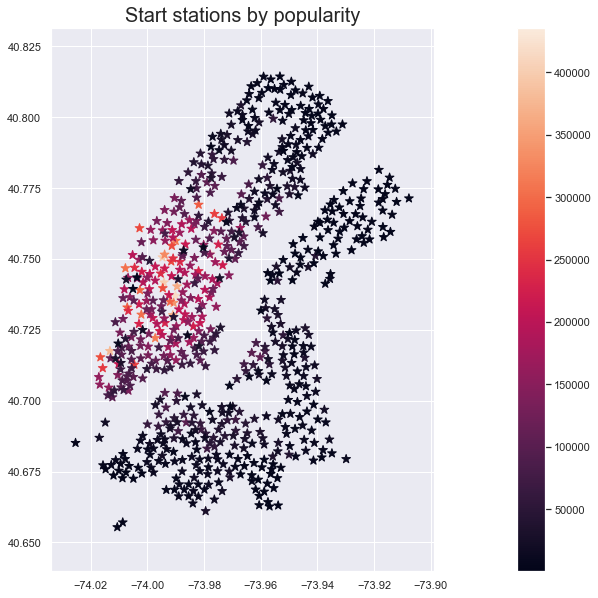

In [17]:
geometry_start = [Point(xy) for xy in zip(start_stations['longitude'], start_stations['latitude'])]
start_stations_gdf = GeoDataFrame(start_stations, crs={'init': 'epsg:4326'}, geometry=geometry_start)
start_stations_gdf.plot(markersize=85, marker='*',column='frequency', legend=True, figsize=(30, 10))
plt.title("Start stations by popularity", fontsize=20)
plt.show()

In [18]:
%%bigquery end_stations

SELECT longitude, latitude, frequency
FROM
(SELECT e_trips.end_station_name, e_trips.frequency, e_stations.latitude, e_stations.longitude 
FROM 
(SELECT end_station_name,
COUNT(end_station_name) AS frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY end_station_name) e_trips, `bigquery-public-data.new_york_citibike.citibike_stations` e_stations
WHERE e_trips.end_station_name = e_stations.name
ORDER BY frequency DESC)

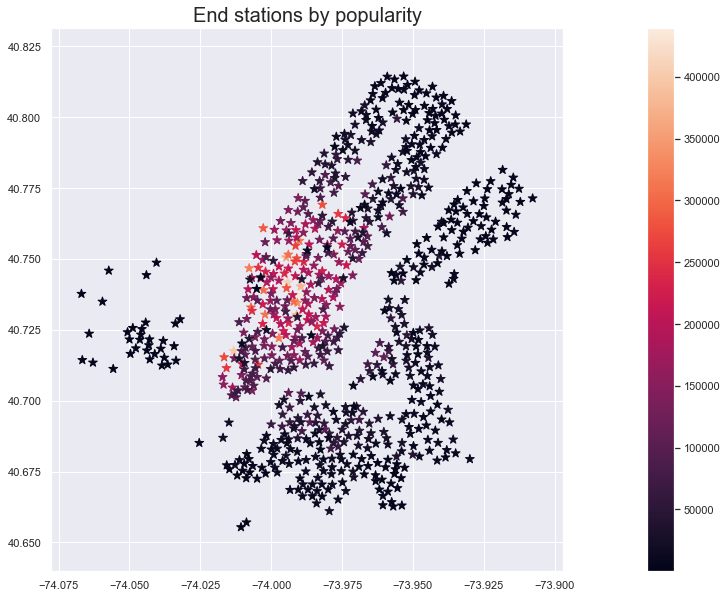

In [19]:
geometry_end = [Point(xy) for xy in zip(end_stations['longitude'], end_stations['latitude'])]
end_stations_gdf = GeoDataFrame(end_stations, crs={'init': 'epsg:4326'},geometry = geometry_end)
end_stations_gdf.plot(markersize=85, marker='*',column='frequency', legend=True, figsize=(30, 10))
plt.title("End stations by popularity", fontsize=20)
plt.show()

<h1 align="center">TASK 2</h1> 

<h3 align="center"> Aim 1: Understand what bikes are used the most.</h3> 

There should be a certain usage treshhold for bike replacement. I assume that bikes which are used the most are more likely to get broken, so it is important to track bike usage. Knowing what bikes are used the most would facilitate their replacement and contribute to users' safety and comfort.

<h3 align="center"> Aim 2: Understand who is a CityBike user.</h3> 

It is important to know who are CityBike's clients: how old they are, are they male or female, what type of subscription they use. This knowledge would allow us, for example, to develop and adjust marketing compaigns (e.g., if women are underepresented among customers, it is important to understand what can attract them).

<h3 align="center"> Aim 3: Understand how time influences CityBike users behaviour.</h3> 

I assume that time of the year, week, day affects CityBike users' behaviour. Understanding of this influence would allow us, for example, to (1) plan and adjust resources needed to maintain stations (e.g., more employees are needed to make sure that bikes are well distributed during pick hours) and (2) personalize ads (e.g., send notifications to users on the days they are more likely to cycle in order to remind them about this possibility and encourage).

<h3 align="center"> Aim 4: Infrom decisions on where to open future stations.</h3> 

Analysis of demographic characteristics of NYC zip areas and knowing who is a typical CityBike user will inform decisions on where to open new stations. 

<h1 align="center">Aim 1: Understand what bikes are used the most</h1> 

<h1 align="center">  1. What are the mostly used bikes? </h1> 

**Answer and comments**: : The distribution of how often bikes were used revealed that several bikes have been used significantly more than other (e.g., the first  5). It is important to understand factors which made these several bikes so popular. Possibly, they were always located at the most popular stations. If this is the case, one needs to check the bike rotation algorithm. In the future, it would help to plot locations of the mostly used bikes to check the hypothesis that they were not well enough rotated.

<h2 align="center">Solution</h2> 

In [20]:
%%bigquery mostly_used_bikes

SELECT bikeid, SUM (ROUND((tripduration/3600))) AS total_triptime_hours
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
GROUP BY bikeid
ORDER BY total_triptime_hours DESC
LIMIT 50

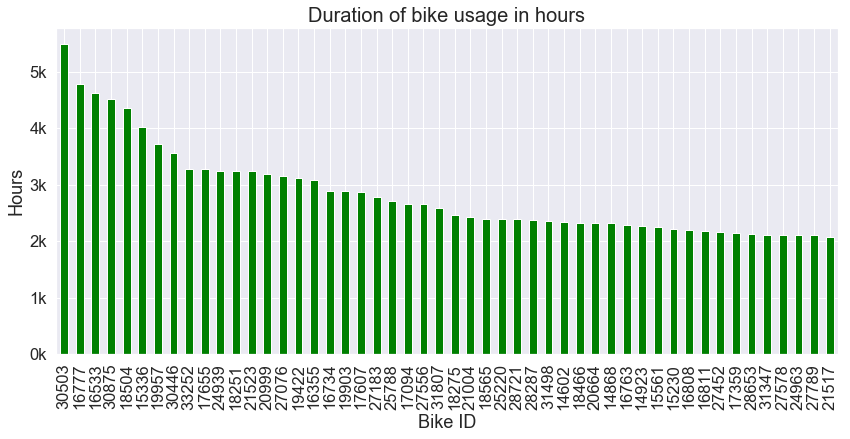

In [21]:
sns.set(font_scale=1.5)
b=mostly_used_bikes.plot(kind='bar', x='bikeid', y='total_triptime_hours', color='green', figsize=(14,6), legend = False)
plt.xlabel('Bike ID', fontsize=18)
plt.ylabel('Hours', fontsize=18)
plt.title("Duration of bike usage in hours", fontsize=20)
ylabels = ['{:.0f}'.format(x) + 'k' for x in b.get_xticks()]
b.set_yticklabels(ylabels)
plt.show()

<h1 align="center">Aim 2: Understand who is a CityBike user.</h1> 

<h1 align="center">  2. What are users' age, gender, and subscription type distributions? </h1> 

**Answers and comments**: 
1. The probability distributions and density curves for males and females below revealed that there is a larger skew towards circa 22-33 yo age range in female users compared to male ones in both customers and subscribers groups. This can inform the marketing team, so they can make ads more attractive for women who are older than 33. 


2. From the descriptive statistics of users' age, I defined the central tendency as 36 yo (median seems to be a better measure than mean since the distribution is positively skewed). 


3. From the descriptive statistics of users' gender, I concluded that there are 3 times more male users than female ones (I have already found this earlier). 


4. From the descriptive statistics of users' type, I found that there are 56 times more subscribers (annual members) than customers. This can inform decisions for marketing strategies also. 

<h2 align="center">Solution</h2> 

In [22]:
%%bigquery users

SELECT usertype, birth_year, gender, customer_plan,
tripduration/60 as tripduration_min,
EXTRACT(YEAR FROM starttime) as the_year
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE birth_year > 1930
AND tripduration BETWEEN 2*60 AND 120*60 
ORDER BY RAND()
LIMIT 100000

In [23]:
users['age'] = users['the_year']-users['birth_year']
bins = np.array([0,25,45,65])
names = ['<25', '25-45', '45-65', '65+']
d = dict(enumerate(names, 1))
users['age_range'] = np.vectorize(d.get)(np.digitize(users['age'], bins))

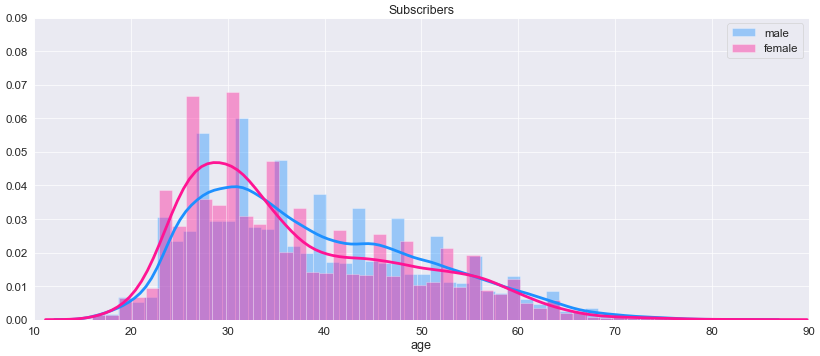

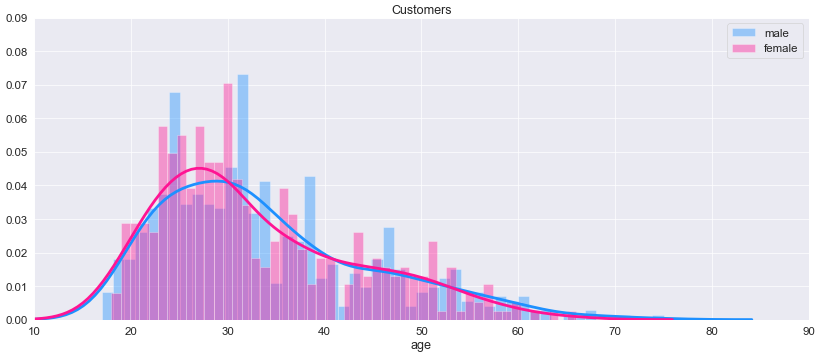

In [24]:
sns.set(font_scale=1.5)

users_subscriber = users[users.usertype == 'Subscriber']
male_subscriber = users_subscriber.loc[users_subscriber.gender=='male', 'age']
female_subscriber = users_subscriber.loc[users_subscriber.gender=='female', 'age']

users_customer = users[users.usertype == 'Customer']
male_customer = users_customer.loc[users_customer.gender=='male', 'age']
female_customer = users_customer.loc[users_customer.gender=='female', 'age']

kwargs = dict(hist_kws={'alpha':.4}, kde_kws={'linewidth':4})

plt.figure(figsize=(20,8), dpi= 50)
sns.distplot(male_subscriber, color="dodgerblue", label="male", **kwargs, bins = 50)
sns.distplot(female_subscriber, color="deeppink", label="female", **kwargs, bins = 50)
plt.xlim(10,90)
plt.ylim(0,0.09)
plt.legend()
plt.title("Subscribers")
plt.show()

plt.figure(figsize=(20,8), dpi= 50)
sns.distplot(male_customer, color="dodgerblue", label="male", **kwargs, bins = 50)
sns.distplot(female_customer , color="deeppink", label="female", **kwargs, bins = 50)
plt.xlim(10,90)
plt.ylim(0,0.09)
plt.legend()
plt.title("Customers")
plt.show()

In [25]:
users[['age']].describe()

age
count  100000.000000
mean       38.234040
std        11.455545
min        16.000000
25%        29.000000
50%        36.000000
75%        46.000000
max        86.000000

In [26]:
users['gender'].value_counts()

male       74854
female     24011
unknown     1135
Name: gender, dtype: int64

In [27]:
users['usertype'].value_counts()

Subscriber    98231
Customer       1769
Name: usertype, dtype: int64

In [28]:
98231/1769

55.52911249293386

<h1 align="center">3. Do users' age, gender, subscription type influence their bike usage behaviour? </h1> 

**Answer and comments:**: Based on the boxplot below, I cocnluded that average tripduration time would be significnatly larger for `Customers` comapred to `Subscribers`, because in the majority of the comparisons the interquartile ranges do not overlap much and `Customers'` medians are always higher. This is an expcted finding, because `Customers` most likely either want to use maximum of the time they paid for (30 minutes for a Single Ride) or they want to explore the city (dayly passes), so using each bike as long as allowed makes sense for them. Contrary, `Subscribers` are most likely locals and they are not limited in eaither number of rides, or time they stay in NYC. 

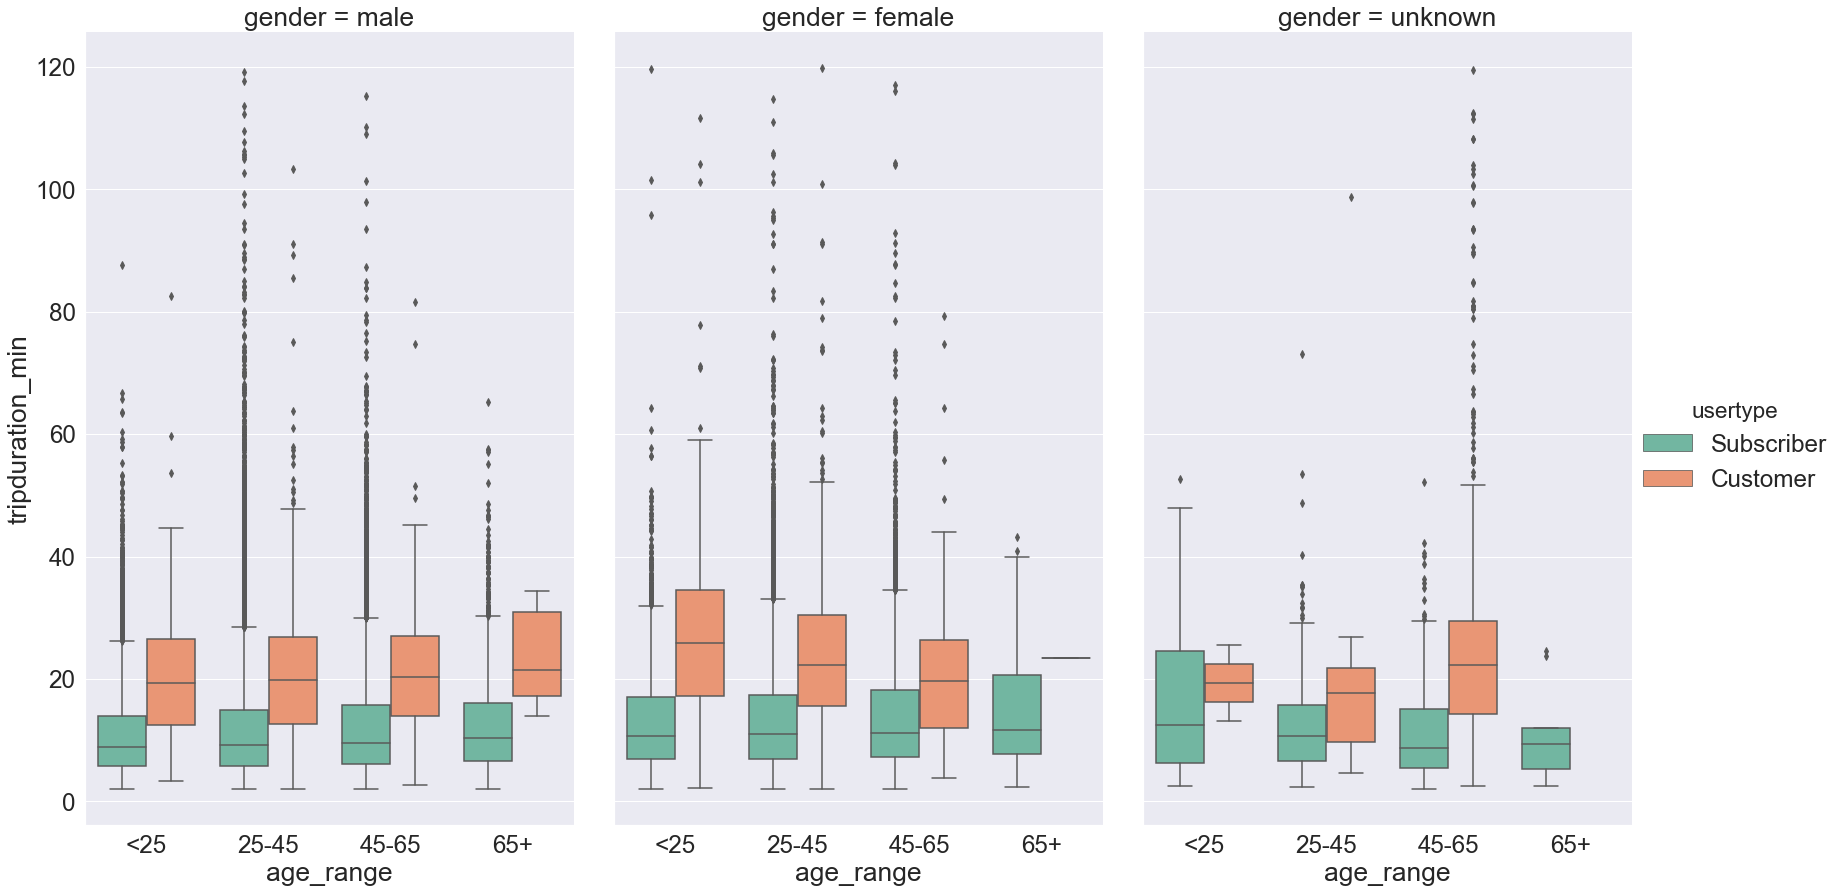

In [32]:
sns.set(font_scale=2.2)
users_plot = sns.catplot(x="age_range", y="tripduration_min", hue="usertype", col="gender", data=users, order=['<25', '25-45', '45-65', '65+'], kind="box", height=13, aspect=0.6, palette = 'Set2', legend = True)
plt.show()

<h1 align="center"> Aim 3: Understand how time influences CityBike users behaviour.</h1> 

<h1 align="center">  4. Are there differences in the number of trips between week days?</h1> 

**Answer and comments**: `Number of trips by weekday` plot (below) showed that users are least active on Monday and there is gradual increase in their cycling activity during the week, so on Thursday it reaches the maximum. I assume that people use CityBikes when they are in a good mood. For many people, it is difficult to be in a very good mood on Monday because they are stressed by the beginning of the work week. Howeevr their mood improves by Friday, because they are anticipating weekends and feel more relaxed. On Saturday and Sunday, there is a drop, because, probably, people stop commuting to work. 

<h2 align="center">Solution</h2> 

In [33]:
%%bigquery trips_by_weekdays

SELECT EXTRACT(DAYOFWEEK FROM starttime) AS the_weekday,
COUNT(EXTRACT(DAYOFWEEK FROM starttime)) as frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE tripduration BETWEEN 2*60 AND 120*60
GROUP BY the_weekday
ORDER BY the_weekday

In [34]:
trips_by_weekdays['weekday_names'] = list(calendar.day_name)
display(trips_by_weekdays)

the_weekday  frequency weekday_names
0            1    6122432        Monday
1            2    7540220       Tuesday
2            3    8042065     Wednesday
3            4    8254938      Thursday
4            5    8132927        Friday
5            6    7753140      Saturday
6            7    6421347        Sunday

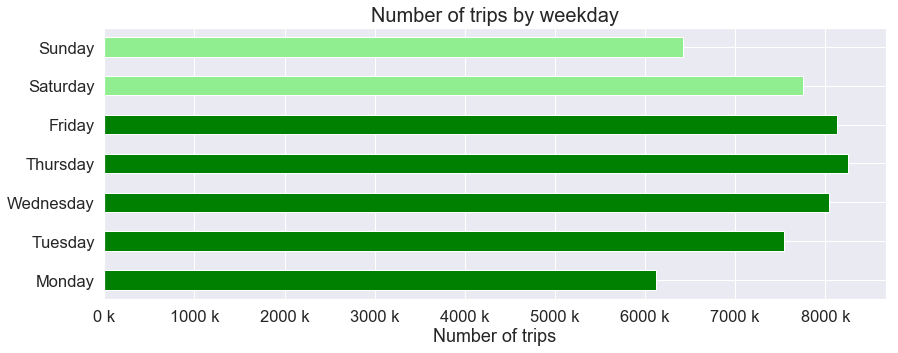

In [35]:
sns.set(font_scale=1.5)
g = trips_by_weekdays.plot.barh(x='weekday_names', y='frequency', color=['green','green','green','green','green','lightgreen','lightgreen'], figsize=(14,5), legend = False)
plt.ylabel('')
plt.xlabel('Number of trips', fontsize=18)
plt.title('Number of trips by weekday', fontsize=20)
xlabels = ['{:.0f}'.format(x) + ' k' for x in g.get_xticks()/1000]
g.set_xticklabels(xlabels)
plt.show()

<h1 align="center">  5. Are there differences in the number of trips during the day?</h1> 

**Answer and comment**: Yes, there are differences in the number of trips users make during the day. For both weekends and working days, the patterns are quite similar: there are 2 periods when users are most active - in the morning from 7 till 9 am and in the evning from 4 till 7 pm. This pattern is very clear for working days, that is expected, beacuse during these periods people commute to work and back home, respectively. For the weekends, the patern is not so clear and users seem to be relatively equally active from 8 am till 7 pm. 

<h2 align="center">Solution</h2> 

In [36]:
%%bigquery trips_by_hours_weekends

SELECT EXTRACT(HOUR FROM starttime) AS the_hour,
COUNT(EXTRACT(HOUR FROM starttime)) as frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE tripduration BETWEEN 2*60 AND 120*60 
AND EXTRACT(DAYOFWEEK FROM starttime) >=6
GROUP BY the_hour
ORDER BY the_hour

In [37]:
%%bigquery trips_by_hours_workdays

SELECT EXTRACT(HOUR FROM starttime) AS the_hour,
COUNT(EXTRACT(HOUR FROM starttime)) as frequency
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE tripduration BETWEEN 2*60 AND 120*60 
AND EXTRACT(DAYOFWEEK FROM starttime) <6
GROUP BY the_hour
ORDER BY the_hour

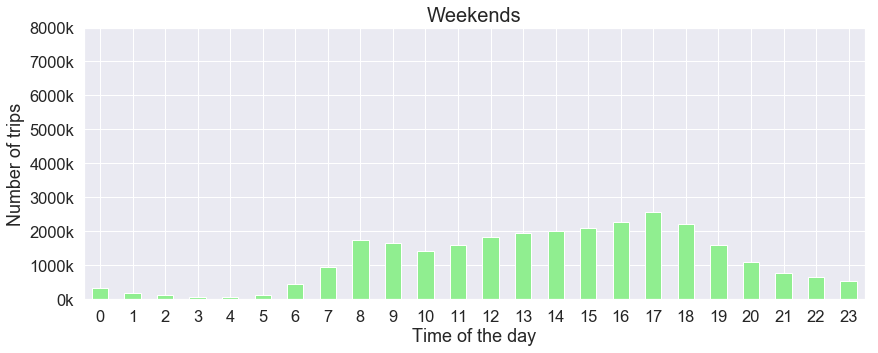

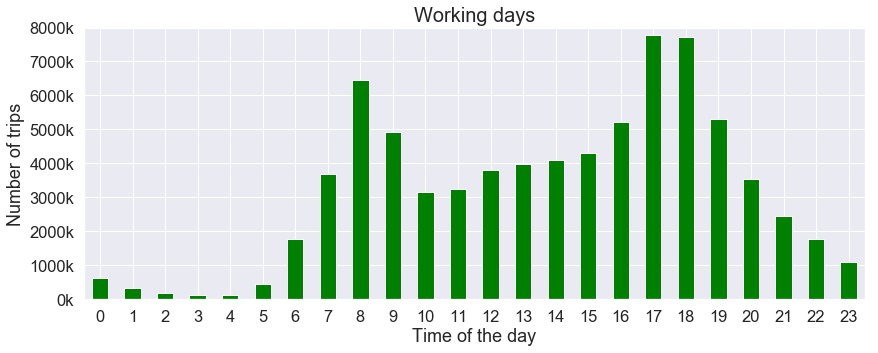

In [38]:
sns.set(font_scale=1.5)

j = trips_by_hours_weekends.plot(kind='bar', x='the_hour', y='frequency', color='lightgreen', figsize=(14,5), legend=False)
plt.ylim(0,4000000)
plt.xlabel('Time of the day', fontsize=18)
plt.ylabel('Number of trips', fontsize=18)
plt.title("Weekends", fontsize=20)
plt.xticks(rotation=0)
ylabels = ['{:.0f}'.format(x) + 'k' for x in g.get_xticks()/1000]
j.set_yticklabels(ylabels)
plt.show()

l = trips_by_hours_workdays.plot(kind='bar', x='the_hour', y='frequency', color='green', figsize=(14,5), legend=False)
plt.ylim(0,4000000)
plt.xlabel('Time of the day', fontsize=18)
plt.ylabel('Number of trips', fontsize=18)
plt.title("Working days", fontsize=20)
plt.xticks(rotation=0)
ylabels = ['{:.0f}'.format(x) + 'k' for x in g.get_xticks()/1000]
l.set_yticklabels(ylabels)
plt.show()

<h1 align="center">  6. Are there differences in trip duration time  between months, days of the week, and during the day?</h1> 

**Answers and comments**: 

1. The `Boxplot grouped by the month` (below) shows that average trip duration is a bit longer from April till September compared to the rest of the months. In January, average trip duration seems to be the smallest. However the differences between the months are not extreme, so CityBike seems to be doing well all year round.


2. Based on the `Boxplot grouped by the weekday` (below), differences in trip duration time do not seem significant between the week days.


3. The `Boxplot grouped by the hour` (below) shows a slight tendency towards longer trips from 11 am till 5 pm.

<h2 align="center">Solution for MONTHS</h2> 

In [39]:
%%bigquery tripduration_by_month

SELECT
ROUND(tripduration/60) AS tripduration_min,
EXTRACT(MONTH FROM starttime) AS the_month
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE tripduration BETWEEN 2*60 AND 120*60 
ORDER BY RAND()
LIMIT 100000

In [40]:
%%bigquery tripduration_by_weekday

SELECT ROUND(tripduration/60) AS tripduration_min,
EXTRACT(DAYOFWEEK FROM starttime) AS the_weekday
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE tripduration BETWEEN 2*60 AND 120*60 
ORDER BY RAND()
LIMIT 100000

In [41]:
%%bigquery tripduration_by_hour

SELECT ROUND(tripduration/60) AS tripduration_min,
EXTRACT(HOUR FROM starttime) AS the_hour
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE tripduration BETWEEN 2*60 AND 120*60 
ORDER BY RAND()
LIMIT 100000

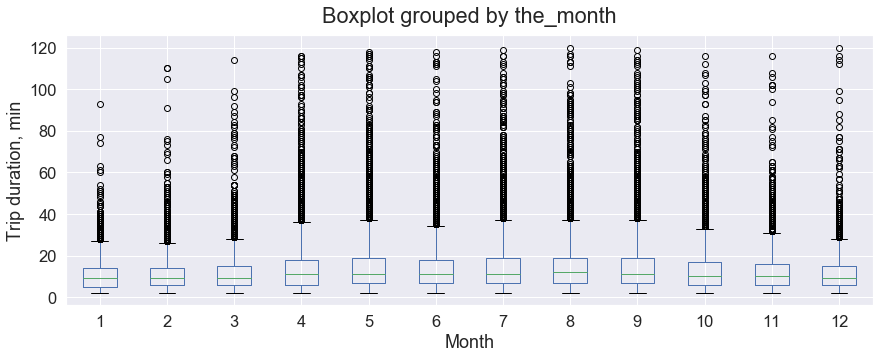

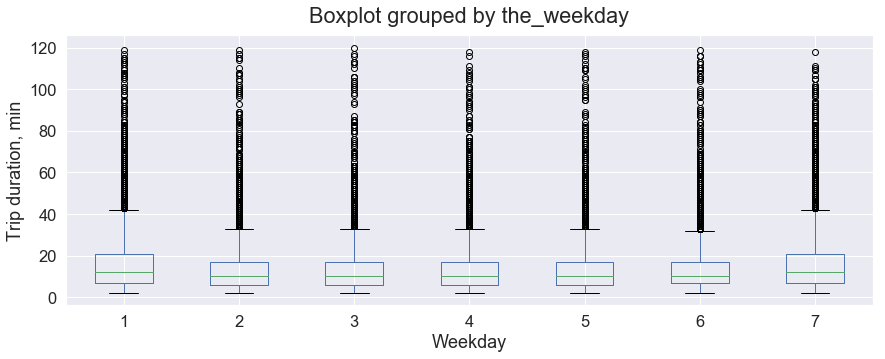

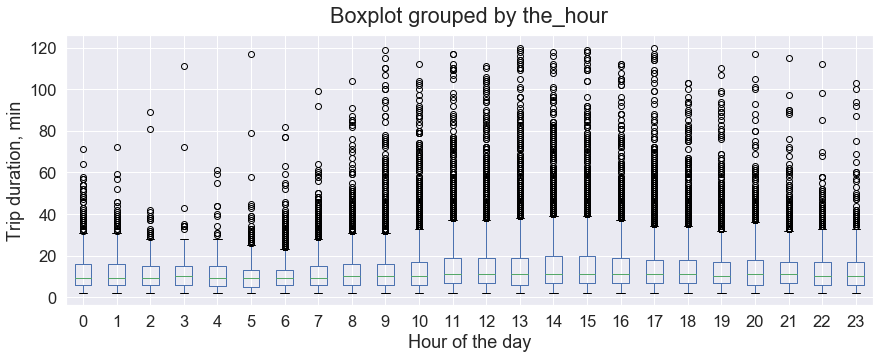

In [42]:
tripduration_by_month.boxplot(column='tripduration_min', by='the_month', figsize=(14,5))
plt.xlabel('Month', fontsize=18)
plt.ylabel('Trip duration, min', fontsize=18)
plt.title("", fontsize=20)
plt.show()

tripduration_by_weekday.boxplot(column='tripduration_min', by='the_weekday', figsize=(14,5))
plt.xlabel('Weekday', fontsize=18)
plt.ylabel('Trip duration, min', fontsize=18)
plt.title("", fontsize=20)
plt.show()

tripduration_by_hour.boxplot(column='tripduration_min', by='the_hour', figsize=(14,5))
plt.xlabel('Hour of the day', fontsize=18)
plt.ylabel('Trip duration, min', fontsize=18)
plt.title("", fontsize=20)
plt.show()

<h1 align="center"> Aim 4: Inform decisions on where to open future stations.</h1> 

<h1 align="center">  7. Exploring potential new areas for installing stations based on GENDER</h1> 

**Answer and comments**: I know that men are 3 times more likely to become CityBike users compared to women. Thus, I might want to open new bike stations in areas with a higher proportion of men. `Proportion of female residents by zip area` plot (below) clearly shows that almost all NYC zip areas have 50/50 male/female ratio. Thus, I can not use gender as a decision factor for choosing areas to open new stations. Let's see whether I can have some luck with age.

<h2 align="center">Solution</h2> 

In [43]:
%%bigquery ny_zip_areas

with
params AS(
SELECT
-74.0060 as lon,
40.7128 as lat,
7.4 as radius -- in miles
),

zipcodes_within_distance as (
SELECT
zipcode
FROM 
`bigquery-public-data.utility_us.zipcode_area` as zip_area, 
params
WHERE 
ST_DWithin(ST_GeogPoint(params.lon, params.lat), ST_GeogPoint(zip_area.longitude , zip_area.latitude ), 1609*params.radius)
),

state_by_zipcode as (
SELECT
zipcode ,
sum(if(gender = '' and minimum_age is null and maximum_age is null, population, 0)) as total,
sum(if(gender = 'female' and minimum_age is null and maximum_age is null, population, 0)) as total_female,
sum(if(gender = 'male' and minimum_age is null and maximum_age is null, population, 0)) as total_male,
sum(if(maximum_age <= 24, population, 0)) as population_0_24,
sum(if(minimum_age >= 25 and maximum_age <= 44, population, 0)) as population_25_44,
sum(if(minimum_age >= 45 and maximum_age <= 64, population, 0)) as population_45_64,
sum(if(minimum_age >= 65, population, 0)) as population_65_plus
FROM `bigquery-public-data.census_bureau_usa.population_by_zip_2010` AS zip_census
WHERE 
zipcode IN (SELECT zipcode FROM zipcodes_within_distance)
GROUP BY zipcode)

SELECT s.*, z.zipcode_geom
FROM state_by_zipcode s
JOIN `bigquery-public-data.utility_us.zipcode_area` z
ON s.zipcode = z.zipcode

In [44]:
#creating a column with proportion of female 
ny_zip_areas['female_proportion'] = ny_zip_areas['total_female']/(ny_zip_areas['total_female']+ny_zip_areas['total_male'])
ny_zip_areas['proportion_0_24'] = round((ny_zip_areas['population_0_24']/ny_zip_areas['population_0_24'].sum())*100)
ny_zip_areas['proportion_25_44'] = round((ny_zip_areas['population_25_44']/ny_zip_areas['population_25_44'].sum())*100)
ny_zip_areas['proportion_45_64'] = round((ny_zip_areas['population_45_64']/ny_zip_areas['population_45_64'].sum())*100)
ny_zip_areas['proportion_65_plus'] = round((ny_zip_areas['population_65_plus']/ny_zip_areas['population_65_plus'].sum())*100)

In [45]:
ny_zip_areas.head(2)

zipcode  total  total_female  total_male  population_0_24  population_25_44  \
0   11237      0         23947       25949            19365             18530   
1   10011      0         24986       25998             8964             21877   

   population_45_64  population_65_plus  \
0              8979                3022   
1             13826                6317   

                                        zipcode_geom  female_proportion  \
0  POLYGON ((-73.934802 40.713373,-73.922711 40.7...           0.479938   
1  POLYGON ((-74.012359 40.743541,-74.008994 40.7...           0.490075   

   proportion_0_24  proportion_25_44  proportion_45_64  proportion_65_plus  
0              2.0               1.0               1.0                 1.0  
1              1.0               2.0               2.0                 1.0

In [47]:
geometry = ny_zip_areas['zipcode_geom'].apply(loads)
ny_zip_areas.gdf = GeoDataFrame(ny_zip_areas, crs={'init': 'epsg:4326'}, geometry = geometry)

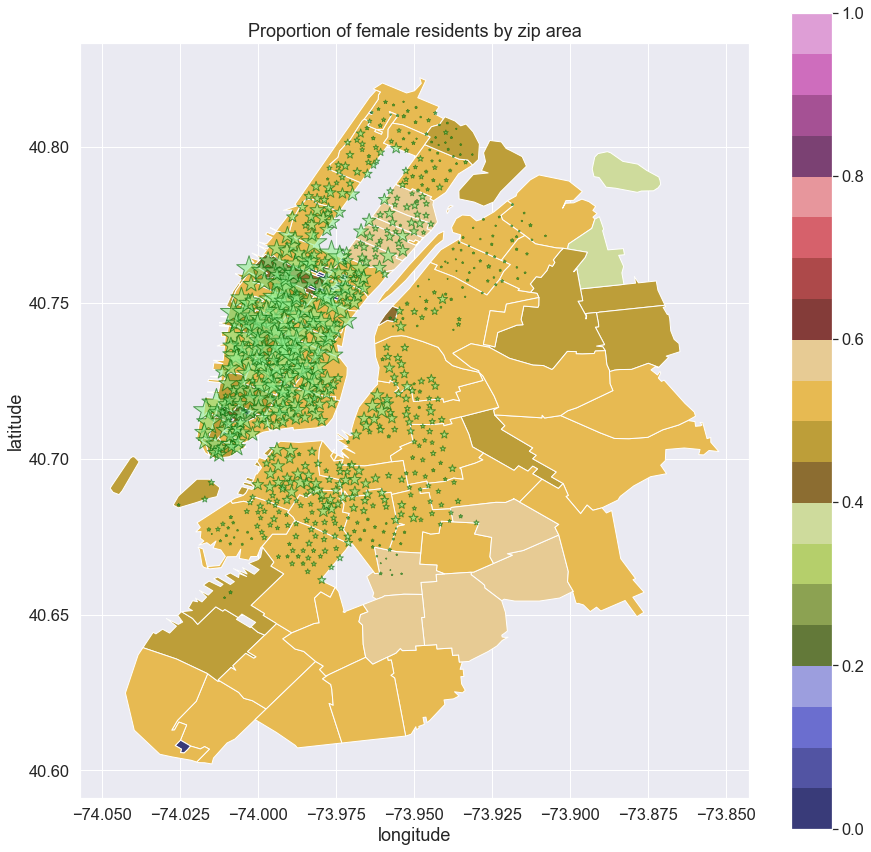

In [49]:
# Plot the zip areas
leg_kwds={'lo<h2 align="center">Solution</h2> c': 'left', 'fontsize': 5}
ny_zip_areas.gdf.plot(column='female_proportion', legend = True, figsize=(15, 15), cmap = "tab20b", legend_kwds = leg_kwds)

# Add the start station locations
plt.scatter(x=start_stations.longitude, y=start_stations.latitude, c='lightgreen', marker = "*", edgecolor='darkgreen',s=start_stations.frequency/400,alpha = 0.6)
plt.title('Proportion of female residents by zip area')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [50]:
ny_zip_areas.gdf.female_proportion.describe()

count    85.000000
mean      0.514622
std       0.089367
min       0.000000
25%       0.500201
50%       0.517891
75%       0.540004
max       1.000000
Name: female_proportion, dtype: float64

<h1 align="center">  8. Exploring potential new areas for installing stations based on AGE</h1> 

**Answer and comments**: I know that 50% of CityBike users are between 29 and 46 yo. Thus, I can pick areas where the majority of residents are close to this age and place bike stations there. Plots below will help me to spot these areas. 

<h2 align="center">Solution</h2> 

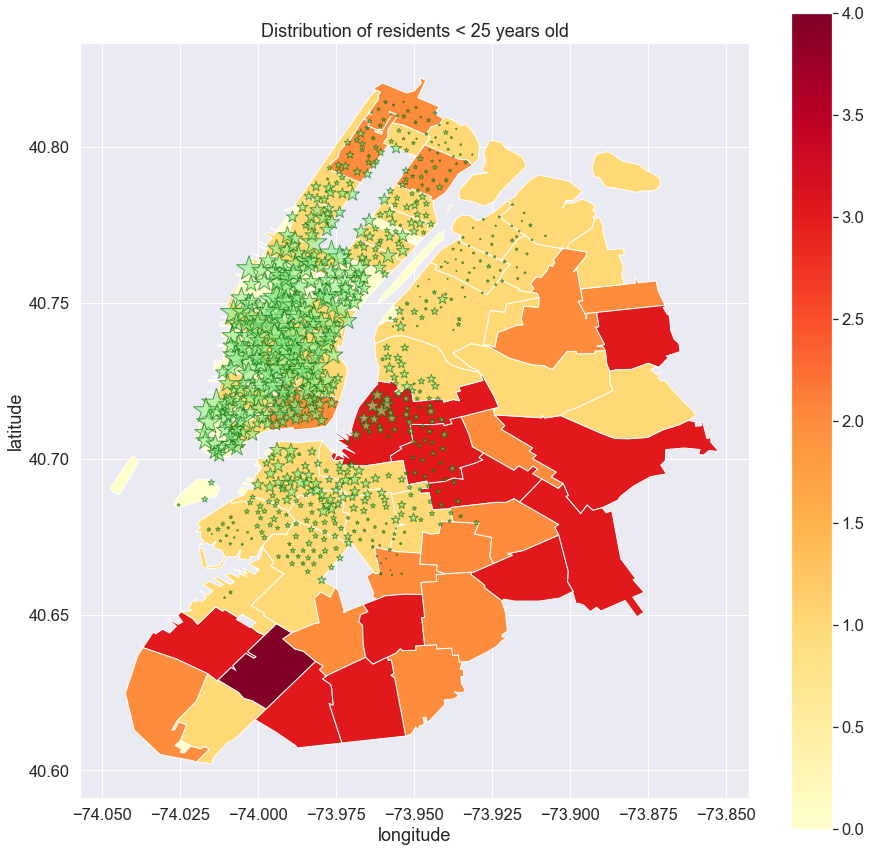

In [56]:
# Plot the zip code areas
ny_zip_areas.gdf.plot(column = 'proportion_0_24', legend = True, figsize=(15,15), cmap = "YlOrRd", legend_kwds = leg_kwds)
# Add the start station locations
plt.scatter(x=start_stations.longitude, y=start_stations.latitude, c='lightgreen', marker = "*", edgecolor='darkgreen',s = start_stations.frequency/400,alpha = 0.6)
plt.title('Distribution of residents < 25 years old')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

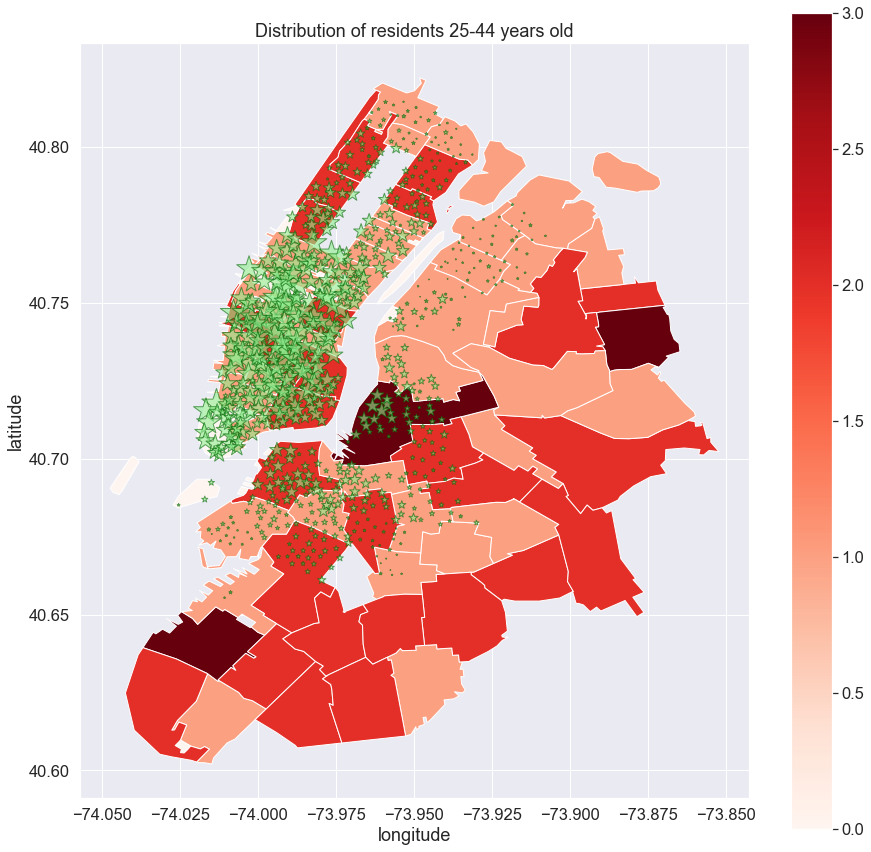

In [57]:
# Plot the zip code areas
ny_zip_areas.gdf.plot(column = 'proportion_25_44', legend = True, figsize=(15,15), cmap = "Reds", legend_kwds = leg_kwds)
# Add the start station locations
plt.scatter(x=start_stations.longitude, y=start_stations.latitude, marker = "*", c = 'lightgreen', edgecolor = 'darkgreen',s = start_stations.frequency/400,alpha = 0.6)
plt.title('Distribution of residents 25-44 years old')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

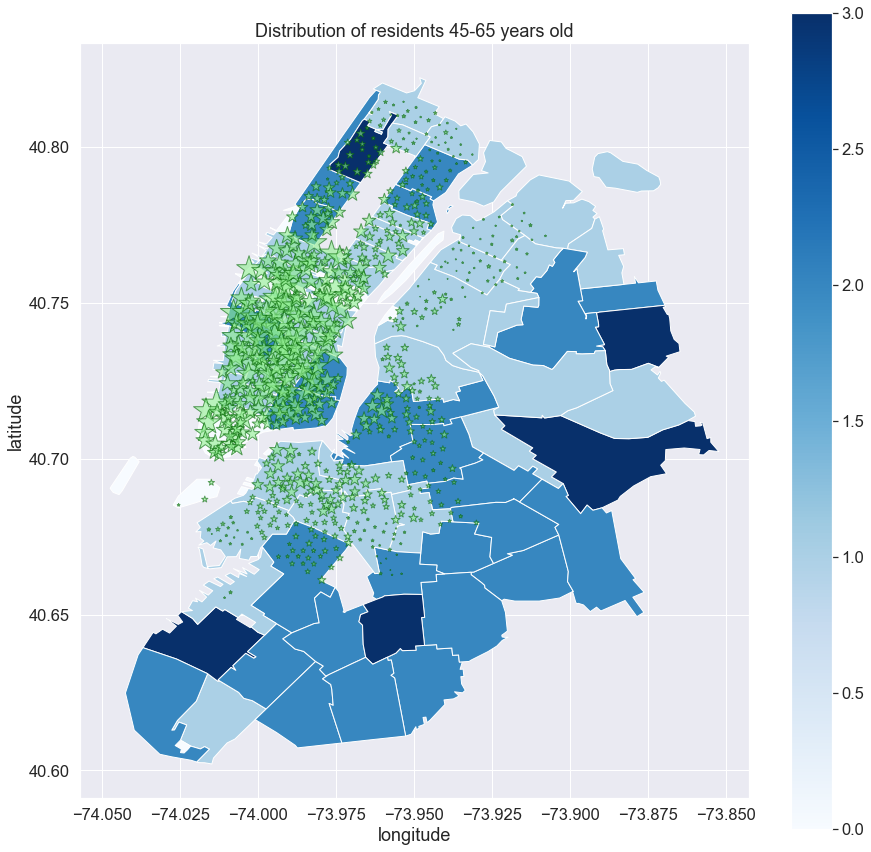

In [58]:
# Plot the zip code areas
ny_zip_areas.gdf.plot(column = 'proportion_45_64', legend = True, figsize=(15,15), cmap = "Blues", legend_kwds = leg_kwds)
# Add the start station locations
plt.scatter(x=start_stations.longitude, y=start_stations.latitude,marker = "*", c = 'lightgreen', edgecolor = 'darkgreen',s = start_stations.frequency/400,alpha = 0.6)
plt.title('Distribution of residents 45-65 years old')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

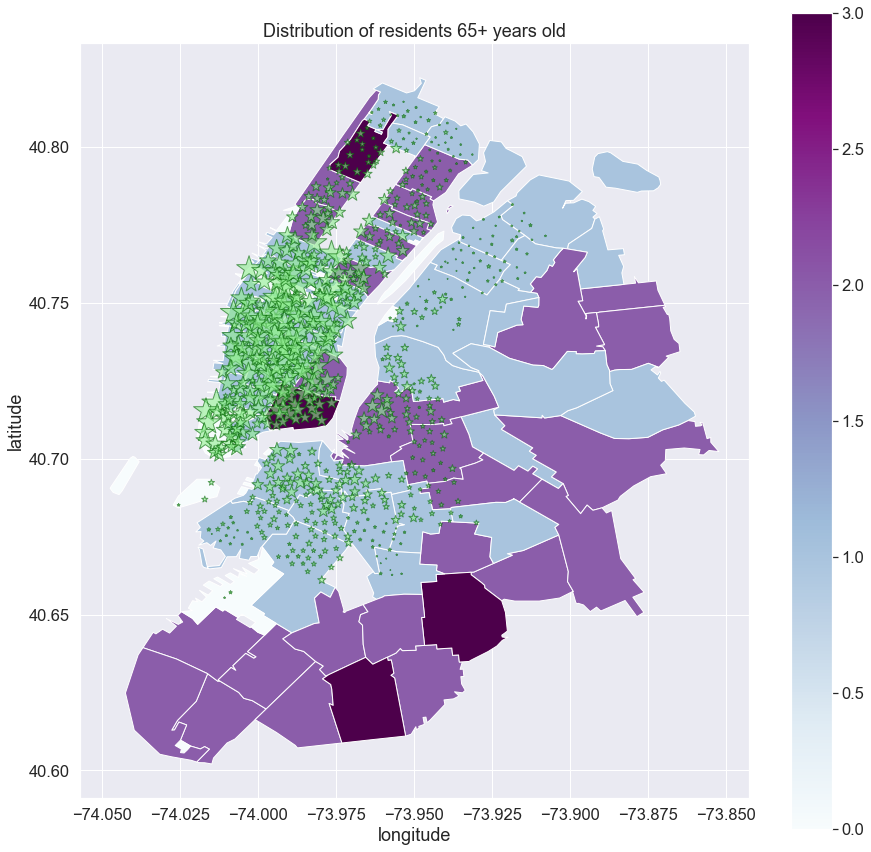

In [59]:
# Plot the zip code areas
ny_zip_areas.gdf.plot(column = 'proportion_65_plus', legend = True, figsize=(15,15), cmap = "BuPu",legend_kwds = leg_kwds)
# Add start station location
plt.scatter(x=start_stations.longitude, y=start_stations.latitude, marker = "*", c = 'lightgreen', edgecolor = 'darkgreen',s = start_stations.frequency/400,alpha = 0.6)
plt.title('Distribution of residents 65+ years old')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

<h1 align="center">FYI</h1> 

To complete this project, I used the following tools:

1. BigQuery console
2. SQL & Python
3. Jupyter Notebooks
4. JupyterLab
5. GeoJSON
6. BigQuery GIS
7. Google Data Studio

I experienced problems installing the **contextily** and this is the reason why there are no contextual basemaps under the map plots.
I've posted the question in Stack Overflow (https://stackoverflow.com/questions/57953146/installing-contextily-on-mac?noredirect=1#comment102318562_57953146) which I find a great way to get help. Further, I will solve this problem. 

Also, I would like to note that GeoJSON displays images only in JupyterLab, so I generated them there and inserted in this notebook as images.

<h1 align="center">REFERENCES</h1> 

- https://www.citibikenyc.com/pricing
- https://cloud.google.com/bigquery/docs/visualize-jupyter
- https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/geojson-extension
- https://cloud.google.com/bigquery/
- Google
- Stack Overflow
- "Working with Geospatial Data in Python" course from DataCamp
- "Visualizing Geospatial Data in Python" course from DataCamp
- YouTube videos
- Several relevant blogposts on geospatial analysis 